In [1]:
from lsst.daf.butler import Butler
import numpy as np
from lsst.rsp import get_tap_service, retrieve_query
import matplotlib.pyplot as plt

In [2]:
butler = Butler('dp02', collections=["u/ameisner/custom_coadd_window1_test1"])

my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}
my_deepCoadd = butler.get('deepCoadd', my_dataId)
my_deepCoadd_photoCalib = my_deepCoadd.getPhotoCalib()

In [3]:
del butler

In [4]:
butler = Butler('dp02', collections=["u/ameisner/custom_coadd_window1_test1_det"])

In [5]:
my_sources = butler.get('deepCoadd_meas', dataId=my_dataId)

In [6]:
# this is will be in the ~5-6k sources range (higher than expected) because it's necessary to trim to 
# detect_isPrimary=True

len(my_sources)

5603

In [7]:
my_sources = my_sources[my_sources['detect_isPrimary'] == True]

In [8]:
# now this very closely matches the original version of notebook 9b to within a few sources

len(my_sources)

2673

In [9]:
my_sources["base_PsfFlux_instFlux"]

array([ 28.58142319,  23.09514315,  22.42529654, ...,  19.51812599,
       218.58003285,  36.09596809])

In [10]:
# mostly copied from original version of notebook 9b

i_CalibMag_AB = np.zeros(len(my_sources), dtype='float')
for s in range(len(my_sources)):
    i_CalibMag_AB[s] = \
    my_deepCoadd_photoCalib.instFluxToMagnitude(my_sources['base_PsfFlux_instFlux'][s])

In [11]:
i_CalibMag_AB


array([23.35979037, 23.59119835, 23.62315451, ..., 23.77390471,
       21.15097378, 23.10635326])

In [12]:
len(i_CalibMag_AB)

2673

Text(0.5, 1.0, 'custom coadd')

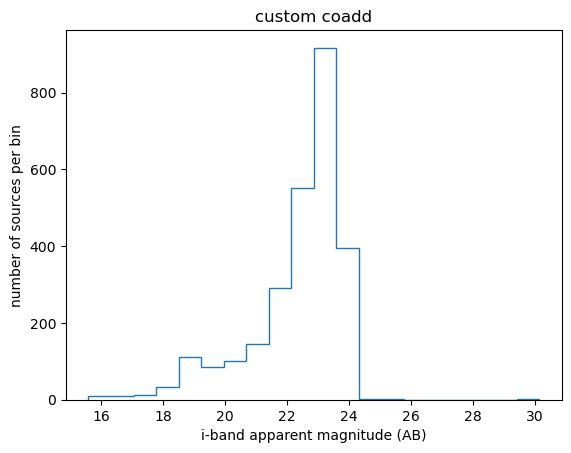

In [18]:
plt.hist(i_CalibMag_AB, bins=20, histtype='step', label='custom coadd')
plt.xlabel("i-band apparent magnitude (AB)")
plt.ylabel("number of detected sources")
plt.title("custom coadd")

In [14]:
tap_service = get_tap_service()

In [15]:
%%time
query = "SELECT objectId, coord_ra, coord_dec, detect_isPrimary, " + \
        "scisql_nanojanskyToAbMag(i_calibFlux) AS i_calibMag, " + \
        "scisql_nanojanskyToAbMagSigma(i_calibFlux, i_calibFluxErr) AS i_calibMagErr, " + \
        "i_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', 55.757, -32.295, 0.2)) = 1 " + \
        "AND i_calibFlux/i_calibFluxErr >= 10 " + \
        "AND detect_isPrimary = 1"

tap_results = tap_service.search(query)
tap_table = tap_results.to_table().to_pandas()

CPU times: user 330 ms, sys: 14.8 ms, total: 345 ms
Wall time: 5.59 s


In [16]:
len(tap_table)

13297

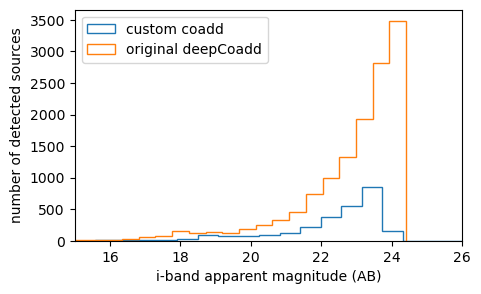

In [19]:

plt.figure(figsize=(5, 3))

plt.hist(i_CalibMag_AB, bins=25, histtype='step', label='custom coadd')
plt.hist(tap_table['i_calibMag'], bins=20, histtype='step', label='original deepCoadd')

plt.xlabel('i-band apparent magnitude (AB)')
plt.ylabel('number of detected sources')
plt.legend(loc='upper left')
plt.xlim([15, 26])
plt.show()

Cutout center (RA, Dec):  (55.7572944294, -32.2945077996)
(12573, 8855.8)


<Figure size 640x480 with 0 Axes>

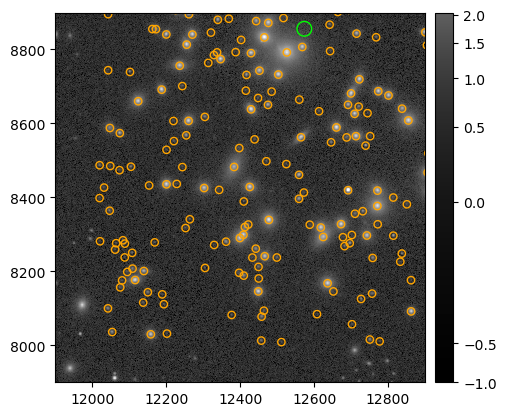

In [24]:
# now try overplotting custom coadd sources on custom coadd image
# strategy is to copy from original version of notebook 9b

import lsst.geom
import lsst.afw.display as afwDisplay
#import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
from astropy.wcs import WCS

afwDisplay.setDefaultBackend('matplotlib')

sources = my_sources # HACK !!

cutout_width = 1000
cutout_height = 1000
my_cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(my_deepCoadd.getX0(),
                                                   my_deepCoadd.getY0()),
                                 lsst.geom.Extent2I(cutout_width, cutout_height))
my_cutout = my_deepCoadd.Factory(my_deepCoadd, my_cutout_bbox)

##

bbox = my_cutout.getBBox()
wcs = my_cutout.wcs
fitsMd = wcs.getFitsMetadata()
WCSfMd = WCS(fitsMd)
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
print('Cutout center (RA, Dec): ', center)

##

sn_coords = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
sn_pix = wcs.skyToPixel(sn_coords)
print(sn_pix)

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_cutout.image)

afw_display.dot('o', sn_pix[0], sn_pix[1], size=20, ctype='green')

with afw_display.Buffering():
    for s in sources:
        afw_display.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

In [26]:
tempButler = Butler('dp02', collections='2.2i/runs/DP0.2')
deepCoadd = tempButler.get('deepCoadd', my_dataId)
deepCoadd_inputs = tempButler.get("deepCoadd.coaddInputs", my_dataId)
len(deepCoadd_inputs.visits.asAstropy())
del tempButler

cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(deepCoadd.getX0(),
                                                deepCoadd.getY0()),
                              lsst.geom.Extent2I(cutout_width, cutout_height))
cutout = deepCoadd.Factory(deepCoadd, cutout_bbox)

wcs = cutout.wcs
temp1 = np.zeros(len(tap_table), dtype='float')
temp2 = np.zeros(len(tap_table), dtype='float')

for i in range(len(tap_table['coord_ra'].values)):
    sP = lsst.geom.SpherePoint(tap_table['coord_ra'][i]*lsst.geom.degrees, \
                               tap_table['coord_dec'][i]*lsst.geom.degrees)
    cpix = wcs.skyToPixel(sP)
    temp1[i] = float(cpix[0])
    temp2[i] = float(cpix[1])
    del sP, cpix

tap_table['cutout_x'] = temp1
tap_table['cutout_y'] = temp2

del wcs, temp1, temp2

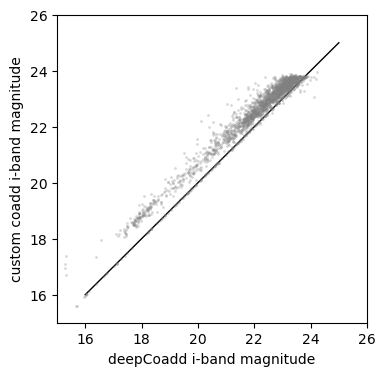

In [28]:
plt.figure(figsize=(4, 4))

plt.plot([16, 25], [16, 25], lw=1, ls='solid', color='black')

for s in range(len(my_sources)):
    tx = np.where((np.abs(my_sources['base_SdssCentroid_x'][s] - tap_table['cutout_x'][:]) < 5.0)
                  & (np.abs(my_sources['base_SdssCentroid_y'][s] - tap_table['cutout_y'][:]) < 5.0))[0]
    if len(tx) == 1:
        plt.plot(tap_table['i_calibMag'][tx[0]],
                 i_CalibMag_AB[s],
                 'o', ms=2, alpha=0.3, mew=0, color='grey')

plt.xlim([15, 26])
plt.ylim([15, 26])
plt.xlabel('deepCoadd i-band magnitude')
plt.ylabel('custom coadd i-band magnitude')
plt.show()